In [1]:
import sys
from pathlib import Path

ROOT = Path().resolve().parent.parent
sys.path.append(str(ROOT))


0%....10....20....30....40....50....60....70....80....90....100%
2025-07-12 18:40:48	WARN	task_tclean::SIImageStore::restore (file /source/casa6/casatools/src/code/synthesis/ImagerObjects/SIImageStore.cc, line 2298)	Restoring with an empty model image. Only residuals will be processed to form the output restored image.


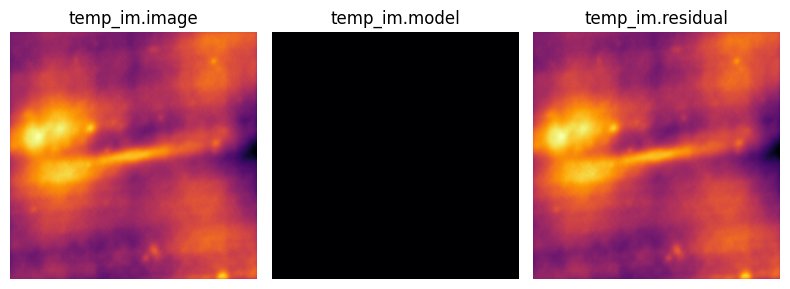

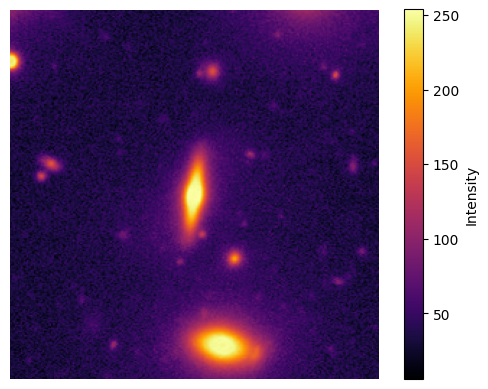

In [3]:
from src.preprocess.imager import Imager
from src.utils.plot import plot_image, plot_fits, plot_ms

image = 'img_0100'
sim = 'sim1'

image_folder = ROOT / 'data/processed' / image
ms_folder = image_folder / sim

ms_path = ms_folder / 'visibilities.ms'

imager = Imager(vis = str(ms_path), output_path=ms_folder)

image_path = image_folder / 'groundtruth.fits'
plot_ms(ms_path=str(ms_path))
plot_fits(fits_path=str(image_path))


0%....10....20....30....40....50....60....70....80....90....100%


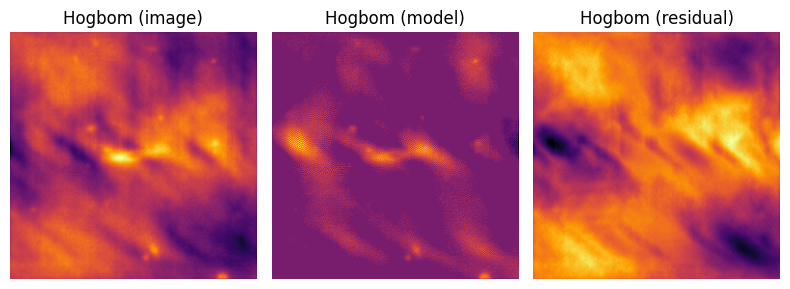

In [6]:
niter_hogbom = 40001
tclean_config = {
    'imsize': 256,
    'cell': '0.02arcsec', # 0.02arcsec
    'niter': niter_hogbom,
    'weighting': 'natural',
}

imager.tclean_hogbom(config=tclean_config)

image_path = ROOT / 'data/processed' / image / sim / f'tclean_hogbom_{niter_hogbom}'
plot_image(image_path=str(image_path), title='Hogbom')

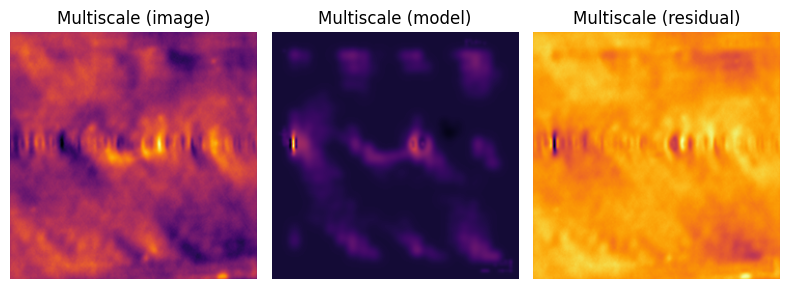

In [7]:
niter_multiscale = 2501
tclean_multiscale_config = {
    'imsize': 256,
    'cell': '0.02arcsec', # 0.02arcsec
    'niter': niter_multiscale,
    'weighting': 'natural',
    'scales': [0,5,15],
}
imager.tclean_multiscale(config=tclean_multiscale_config)
image_path = ROOT / 'data/processed' / image / sim / f'tclean_multiscale_{niter_multiscale}'
plot_image(image_path=str(image_path), title='Multiscale')

Peak Res at start of step : 6.81717
Flux at start of step : 0
MAX RES at end : 2.24797
peakres : 4.80503    model : 8408.38
Peak Res at start of step : 2.26285
Flux at start of step : 8408.38
MAX RES at end : 0.271367
peakres : 2.93946    model : 12301.9


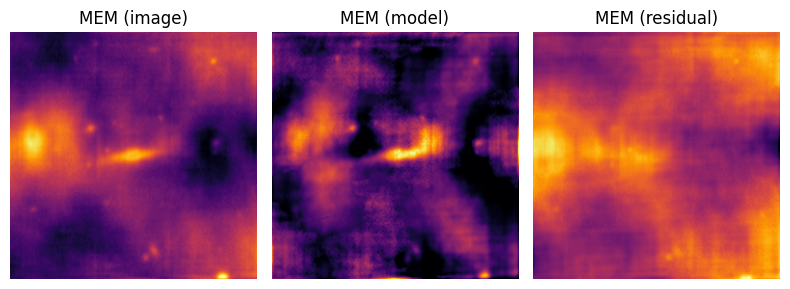

In [8]:
niter_mem = 1001
tclean_mem_config = {
    'imsize': 256,
    'cell': '0.02arcsec',
    'niter': niter_mem,
    'weighting': 'natural',
}

imager.tclean_mem(config=tclean_mem_config)

image_path = ROOT / 'data/processed' / image / sim / f'tclean_mem_{niter_mem}'
plot_image(image_path=str(image_path), title='MEM')

Hogbom: 


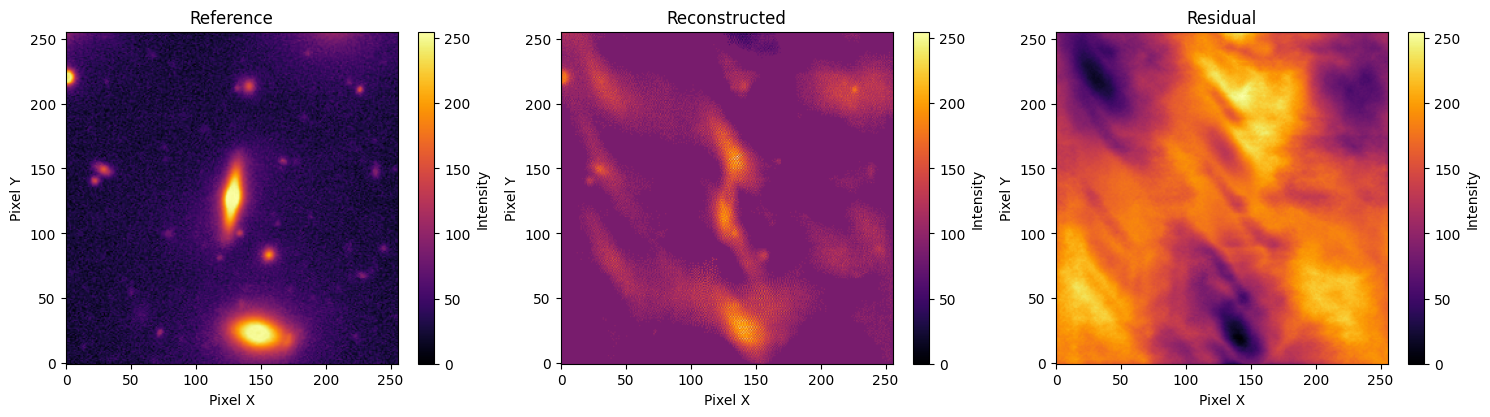

Multiscale: 


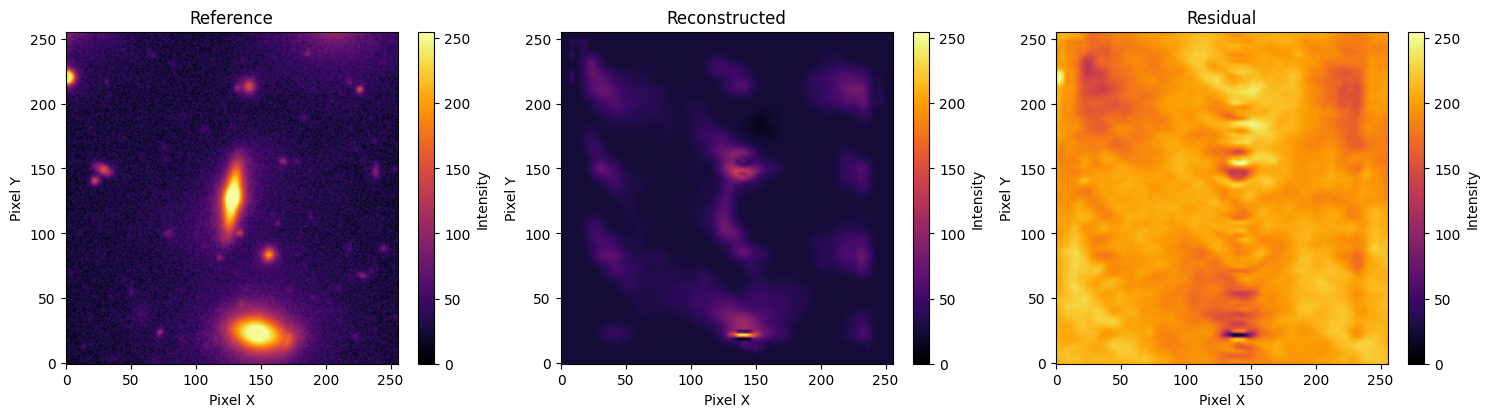

MEM: 


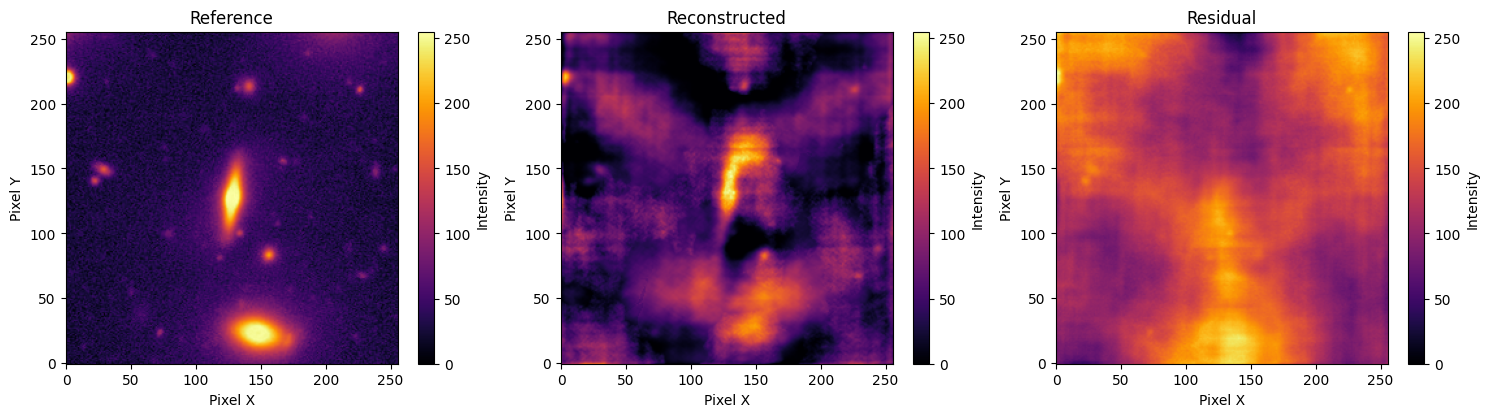

In [10]:
# Calculate image quality metrics of the dirty image
from src.preprocess.image_quality_metrics import ImageQualityMetrics

reference_path = ROOT / 'data/processed' / image / 'groundtruth.fits'
type_image = 'model'

image_path = ROOT / 'data/processed' / image / sim / f'tclean_hogbom_{niter_hogbom}' / f'tclean_hogbom_{niter_hogbom}.{type_image}'
residual_path = ROOT / 'data/processed' / image / sim / f'tclean_hogbom_{niter_hogbom}' / f'tclean_hogbom_{niter_hogbom}.residual'
iqm = ImageQualityMetrics(
    image_path=str(image_path), 
    residual_path=str(residual_path), 
    reference_path=str(reference_path)
)

multiscale_image_path = ROOT / 'data/processed' / image / sim / f'tclean_multiscale_{niter_multiscale}' / f'tclean_multiscale_{niter_multiscale}.{type_image}'
multiscale_residual_path = ROOT / 'data/processed' / image / sim / f'tclean_multiscale_{niter_multiscale}' / f'tclean_multiscale_{niter_multiscale}.residual'
iqm_multiscale = ImageQualityMetrics(
    image_path=str(multiscale_image_path), 
    residual_path=str(multiscale_residual_path), 
    reference_path=str(reference_path)
)

mem_image_path = ROOT / 'data/processed' / image / sim / f'tclean_mem_{niter_mem}' / f'tclean_mem_{niter_mem}.{type_image}'
mem_residual_path = ROOT / 'data/processed' / image / sim / f'tclean_mem_{niter_mem}' / f'tclean_mem_{niter_mem}.residual'
iqm_mem = ImageQualityMetrics(
    image_path=str(mem_image_path), 
    residual_path=str(mem_residual_path), 
    reference_path=str(reference_path)
)

print("Hogbom: ")
iqm.plot_images()

print("Multiscale: ")
iqm_multiscale.plot_images()

print("MEM: ")
iqm_mem.plot_images()

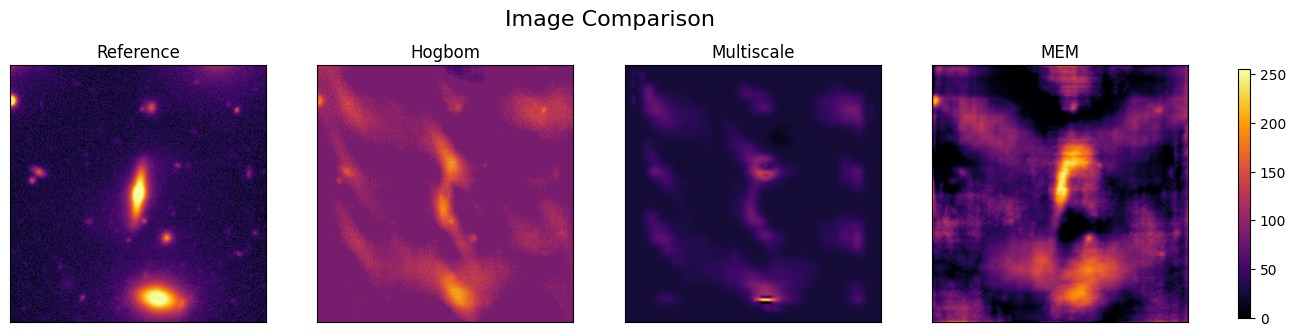

In [11]:
data_reference = iqm.data_reference
data_hogbom = iqm.data_image
data_multiscale = iqm_multiscale.data_image
data_mem = iqm_mem.data_image

import numpy as np
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 4, figsize=(16,16))
cmap = 'inferno'

vmin = min(np.min(data_reference), np.min(data_hogbom), np.min(data_multiscale), np.min(data_mem))
vmax = max(np.max(data_reference), np.max(data_hogbom), np.max(data_multiscale), np.max(data_mem))

im0 = axs[0].imshow(data_reference, cmap=cmap, vmin=vmin, vmax=vmax)
axs[0].set_title('Reference')
im1 = axs[1].imshow(data_hogbom, cmap=cmap, vmin=vmin, vmax=vmax)
axs[1].set_title('Hogbom')
im2 = axs[2].imshow(data_multiscale, cmap=cmap, vmin=vmin, vmax=vmax)
axs[2].set_title('Multiscale')
im3 = axs[3].imshow(data_mem, cmap=cmap, vmin=vmin, vmax=vmax)
axs[3].set_title('MEM')

for ax in axs.flat:
    ax.invert_yaxis()
    ax.label_outer()
    ax.set_xticks([])
    ax.set_yticks([])

fig.suptitle('Image Comparison', fontsize=16, y=0.61)
fig.colorbar(im0, ax=axs, orientation='vertical', fraction=0.01, pad=0.04)
plt.show()
